<a href="https://colab.research.google.com/github/tomonari-masada/course2021-sml/blob/main/07_linear_regression_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 重回帰による住宅価格の予測

* California housing datasetという有名なデータセットを使う。

 * scikit-learnからロードできるバージョンは、前処理が済んだキレイなデータなので、ここでは使わない。

* データの取得や前処理の一部は、
[Aurélien Géron. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition.](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) の2章と同じ。

In [ ]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

%config InlineBackend.figure_format = 'retina'

### 1) データを取得

In [ ]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  os.makedirs(housing_path, exist_ok=True)
  tgz_path = os.path.join(housing_path, "housing.tgz")
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

In [ ]:
fetch_housing_data()

In [ ]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

（ここより上の詳細はフォローしなくてもいいいです。）

In [ ]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### 2) データを概観しつつ前処理

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
# 数値データではない列が一つだけある
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
# この数値データではない列を消してしまう
# （ここを変更してもいいです）
housing_num = housing.drop('ocean_proximity', axis=1)

In [ ]:
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [ ]:
# Non-Null Countが他より少ない列がある
# ここでは単に削除することにする
# （ここを変更してもいいです）
housing_num = housing_num.dropna(subset=['total_bedrooms'])

In [ ]:
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20433 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
dtypes: float64(9)
memory usage: 1.6 MB


In [ ]:
# 説明変数と目的変数を分ける
X = housing_num.drop('median_house_value', axis=1)
y = housing_num["median_house_value"].copy()

### 3) 評価実験のための準備

In [ ]:
# test setを取り除いておく
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 4) 訓練データをよくよくながめてみる

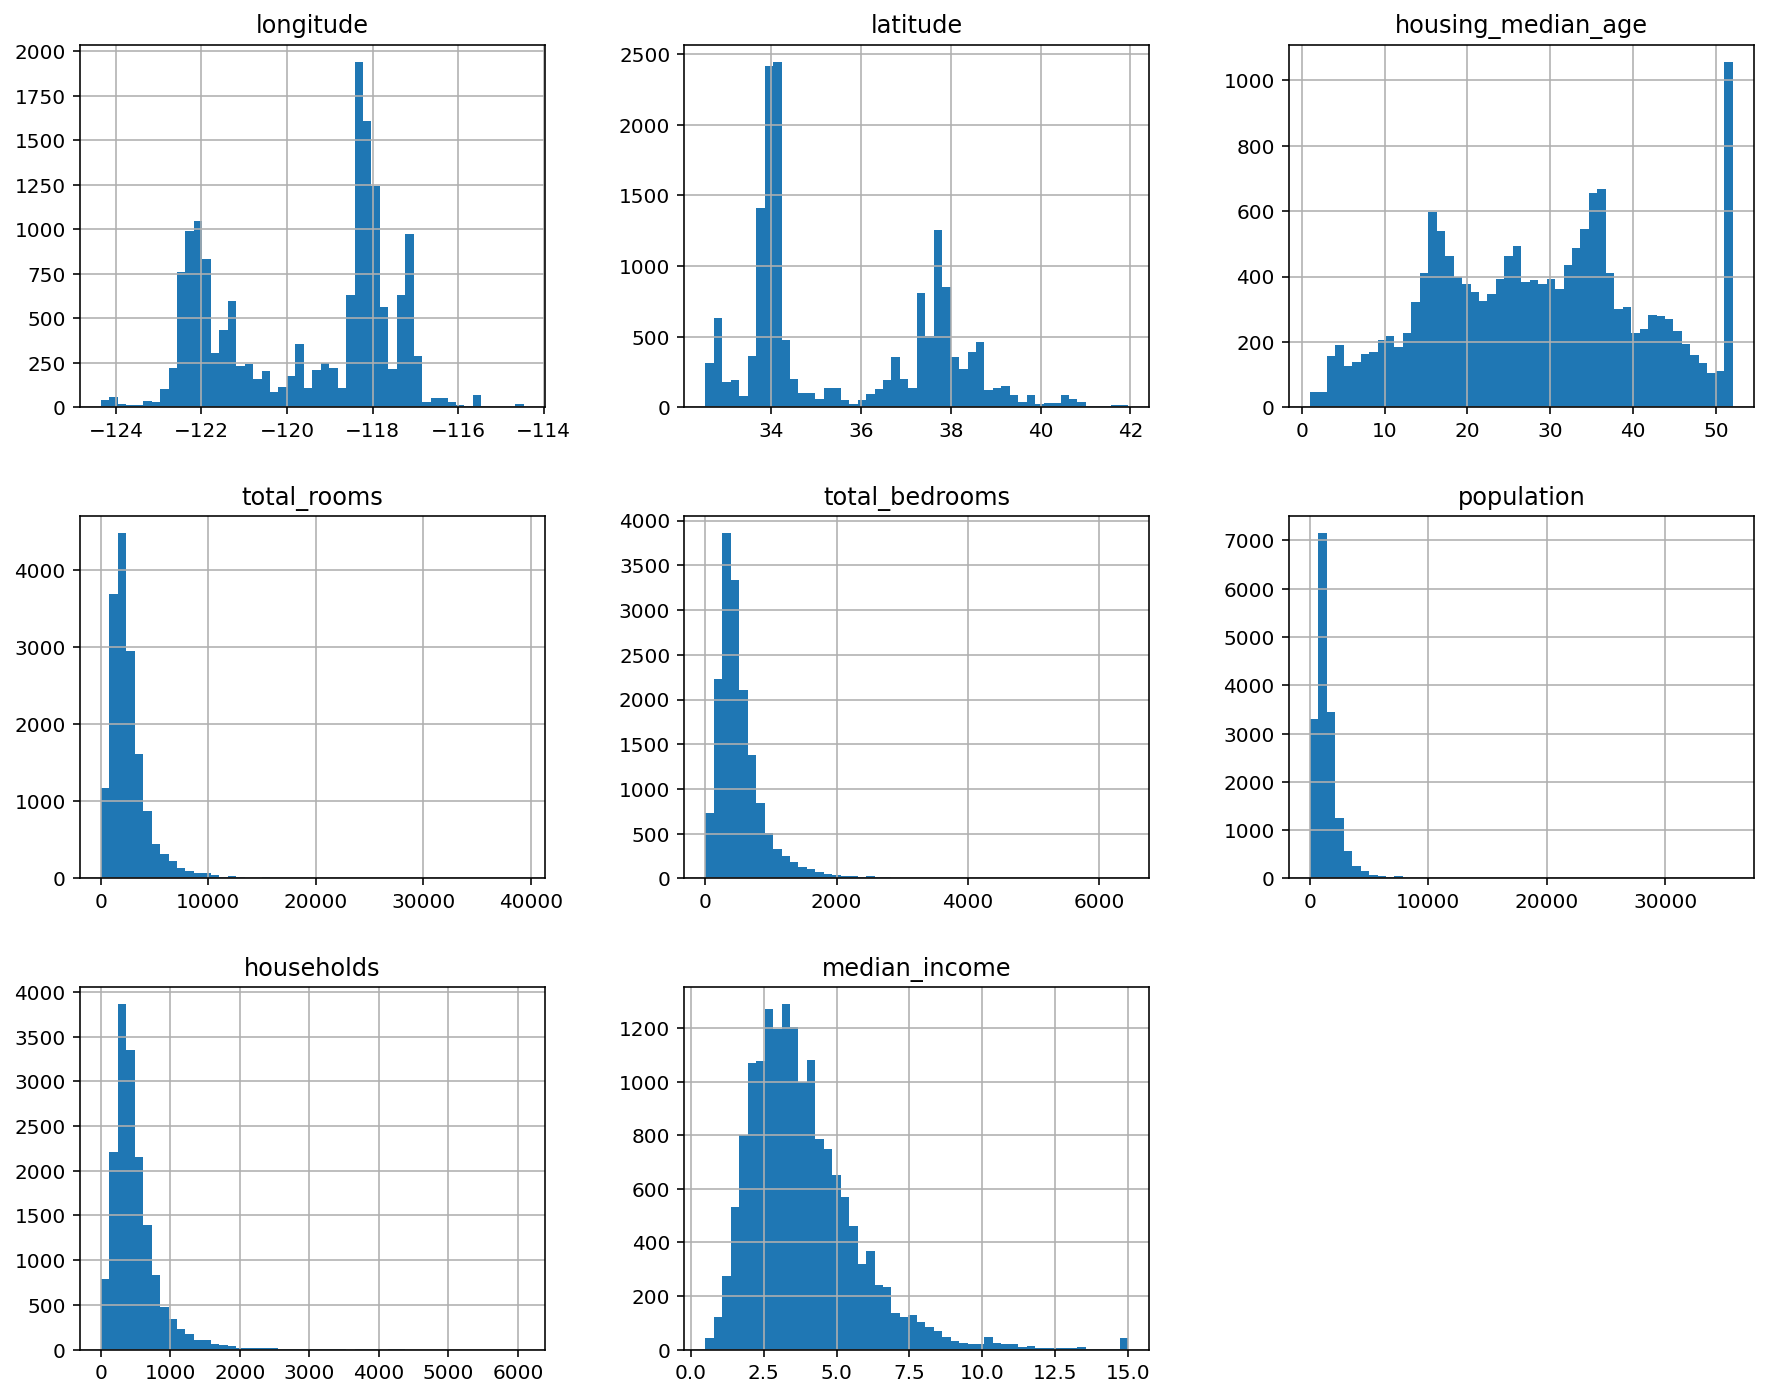

In [ ]:
# ヒストグラムを描く
# (cf. Aurélien Géron. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition. p.50)
X_train.hist(bins=50, figsize=(15,12))
plt.show()

In [ ]:
X_train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000,16346.000000
mean,-119.580513,35.640569,28.615013,2626.293466,536.057751,1420.589991,497.613483,3.870697
std,2.005898,2.136181,12.577173,2153.306818,417.470689,1129.376716,377.997450,1.897825
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.810000,33.930000,18.000000,1450.000000,295.250000,787.000000,280.000000,2.564550
50%,-118.510000,34.260000,29.000000,2125.000000,434.000000,1165.000000,408.000000,3.536650
75%,-118.010000,37.720000,37.000000,3131.750000,646.000000,1720.000000,603.000000,4.750000
max,-114.470000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100


(array([1.171e+03, 3.696e+03, 4.478e+03, 2.957e+03, 1.621e+03, 8.760e+02,
        4.410e+02, 3.120e+02, 2.210e+02, 1.320e+02, 9.700e+01, 6.600e+01,
        6.700e+01, 4.600e+01, 2.400e+01, 2.600e+01, 1.800e+01, 1.200e+01,
        1.100e+01, 1.500e+01, 9.000e+00, 5.000e+00, 8.000e+00, 8.000e+00,
        5.000e+00, 4.000e+00, 4.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([2.000000e+00, 7.883600e+02, 1.574720e+03, 2.361080e+03,
        3.147440e+03, 3.933800e+03, 4.720160e+03, 5.506520e+03,
        6.292880e+03, 7.079240e+03, 7.865600e+03, 8.651960e+03,
        9.438320e+03, 1.022468e+04, 1.101104e+04, 1.179740e+04,
        1.258376e+04, 1.337012e+04, 1.415648e+04, 1.494284e+04,
        1.572920e+04, 1.651556e+04, 1.730192e+04, 1.8088

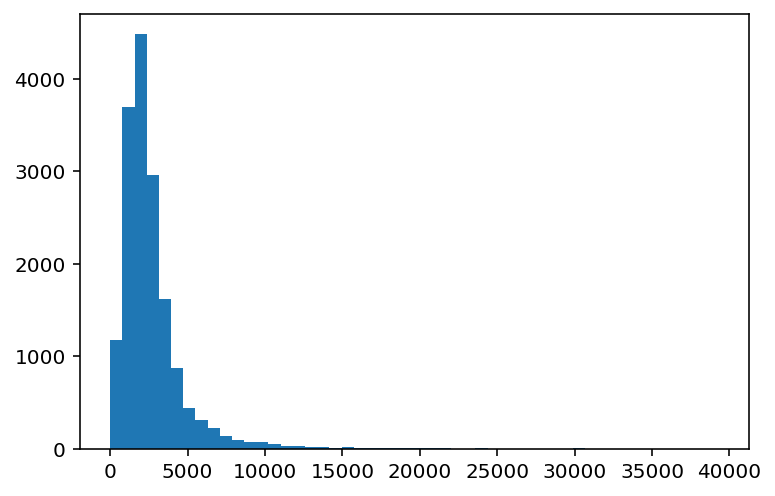

In [ ]:
# total_roomsの値の分布に注目してみる
plt.hist(X_train.total_rooms, bins=50)

* 説明変数の値がどのように分布するかは、回帰モデルの予測性能に直接は関係しない。
 * 回帰モデルでは、誤差項が正規分布に従うという仮定はする。
 * しかし、説明変数の値の分布については、何も仮定しない。
  * 例えば、0か1かの2通りの値しかとらない説明変数もよく使う。
 * とはいえ、それで予測性能が上がるなら、説明変数の値の分布を変更してみる余地はある。

0.22513320746392282


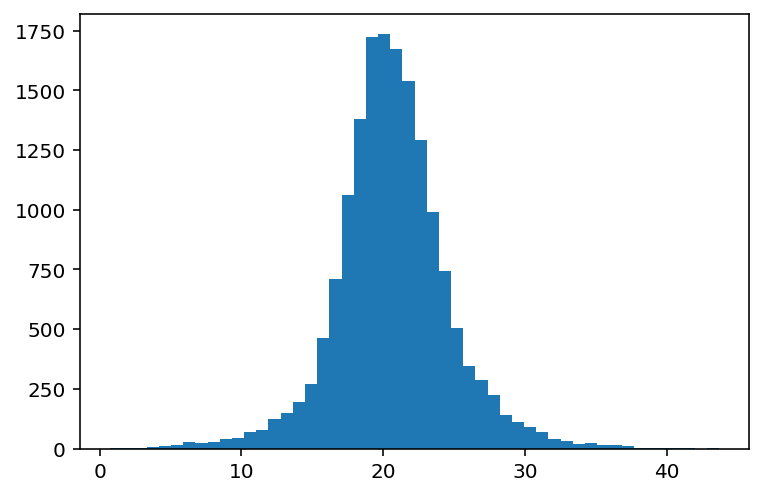

In [ ]:
# total_roomsについて、scipyのBox-Cox変換を適用して、ヒストグラムを描いてみる
boxcox_, maxlog_ = stats.boxcox(X_train.total_rooms)
plt.hist(boxcox_, bins=50)
print(maxlog_)
# （maxlog_ の部分は、test setなど、別のデータ集合を同じ条件で変換するときに使う。）

* 変換した後のデータを使うほうが予測性能がよくなるかどうか、後で試してみよう。

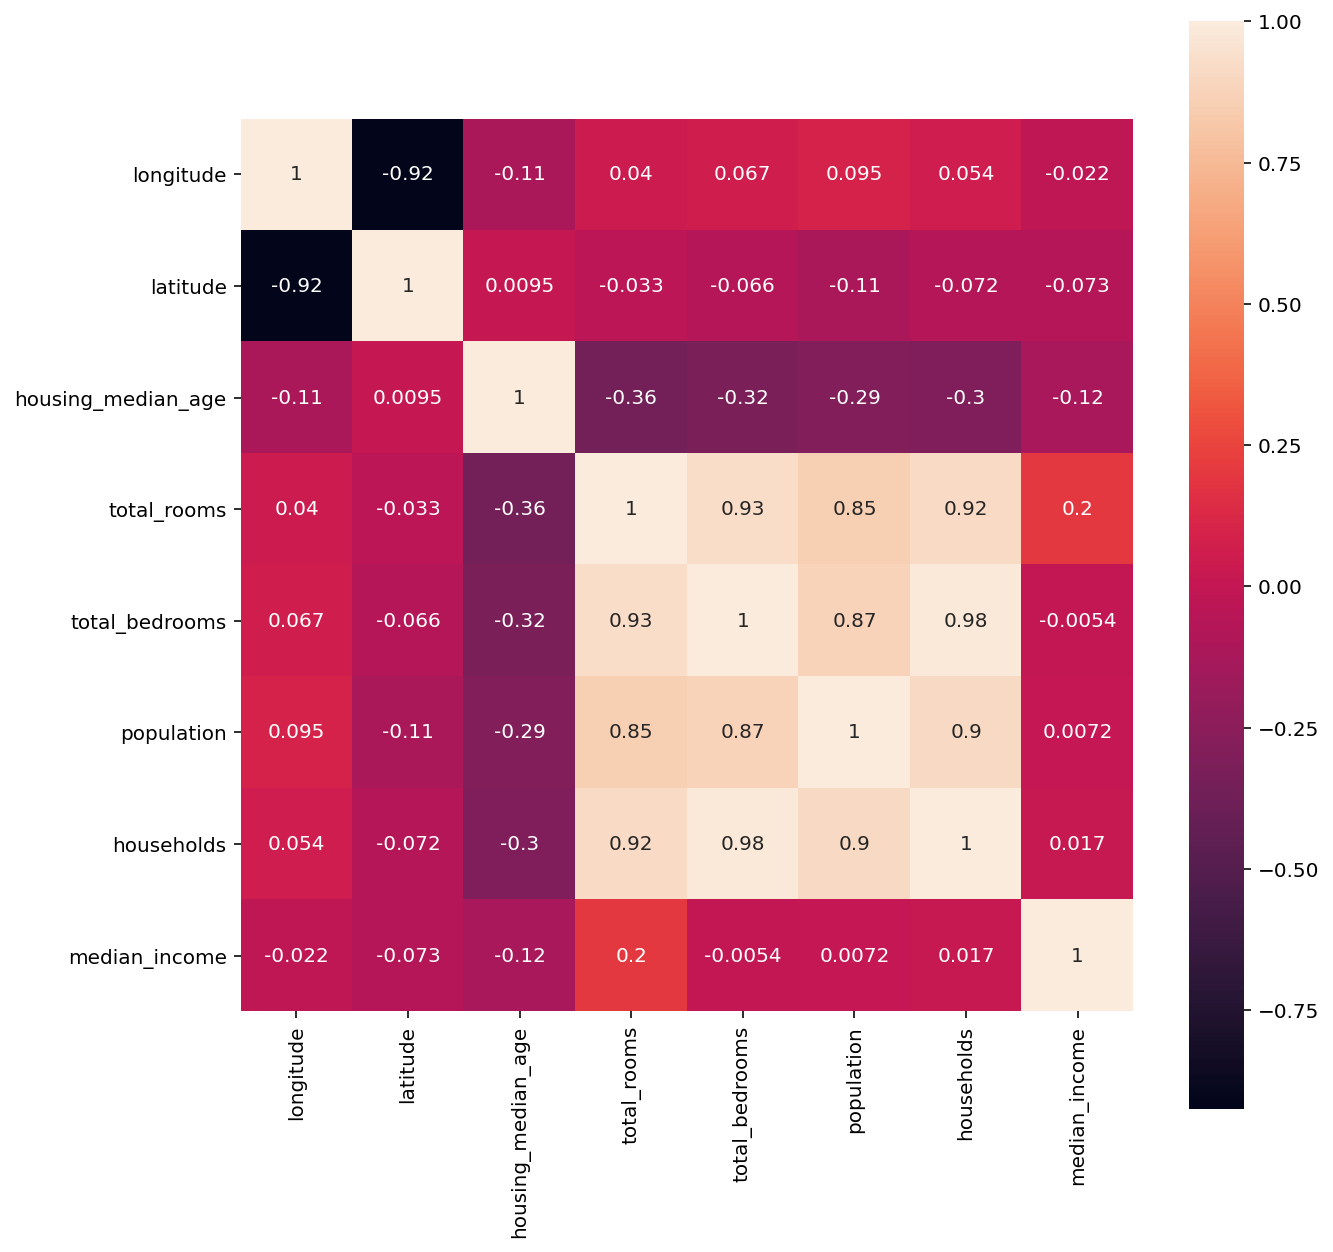

In [ ]:
# 相関係数のヒートマップ
plt.subplots(figsize=(10,10))
sns.heatmap(X_train.corr(), annot=True, square=True)

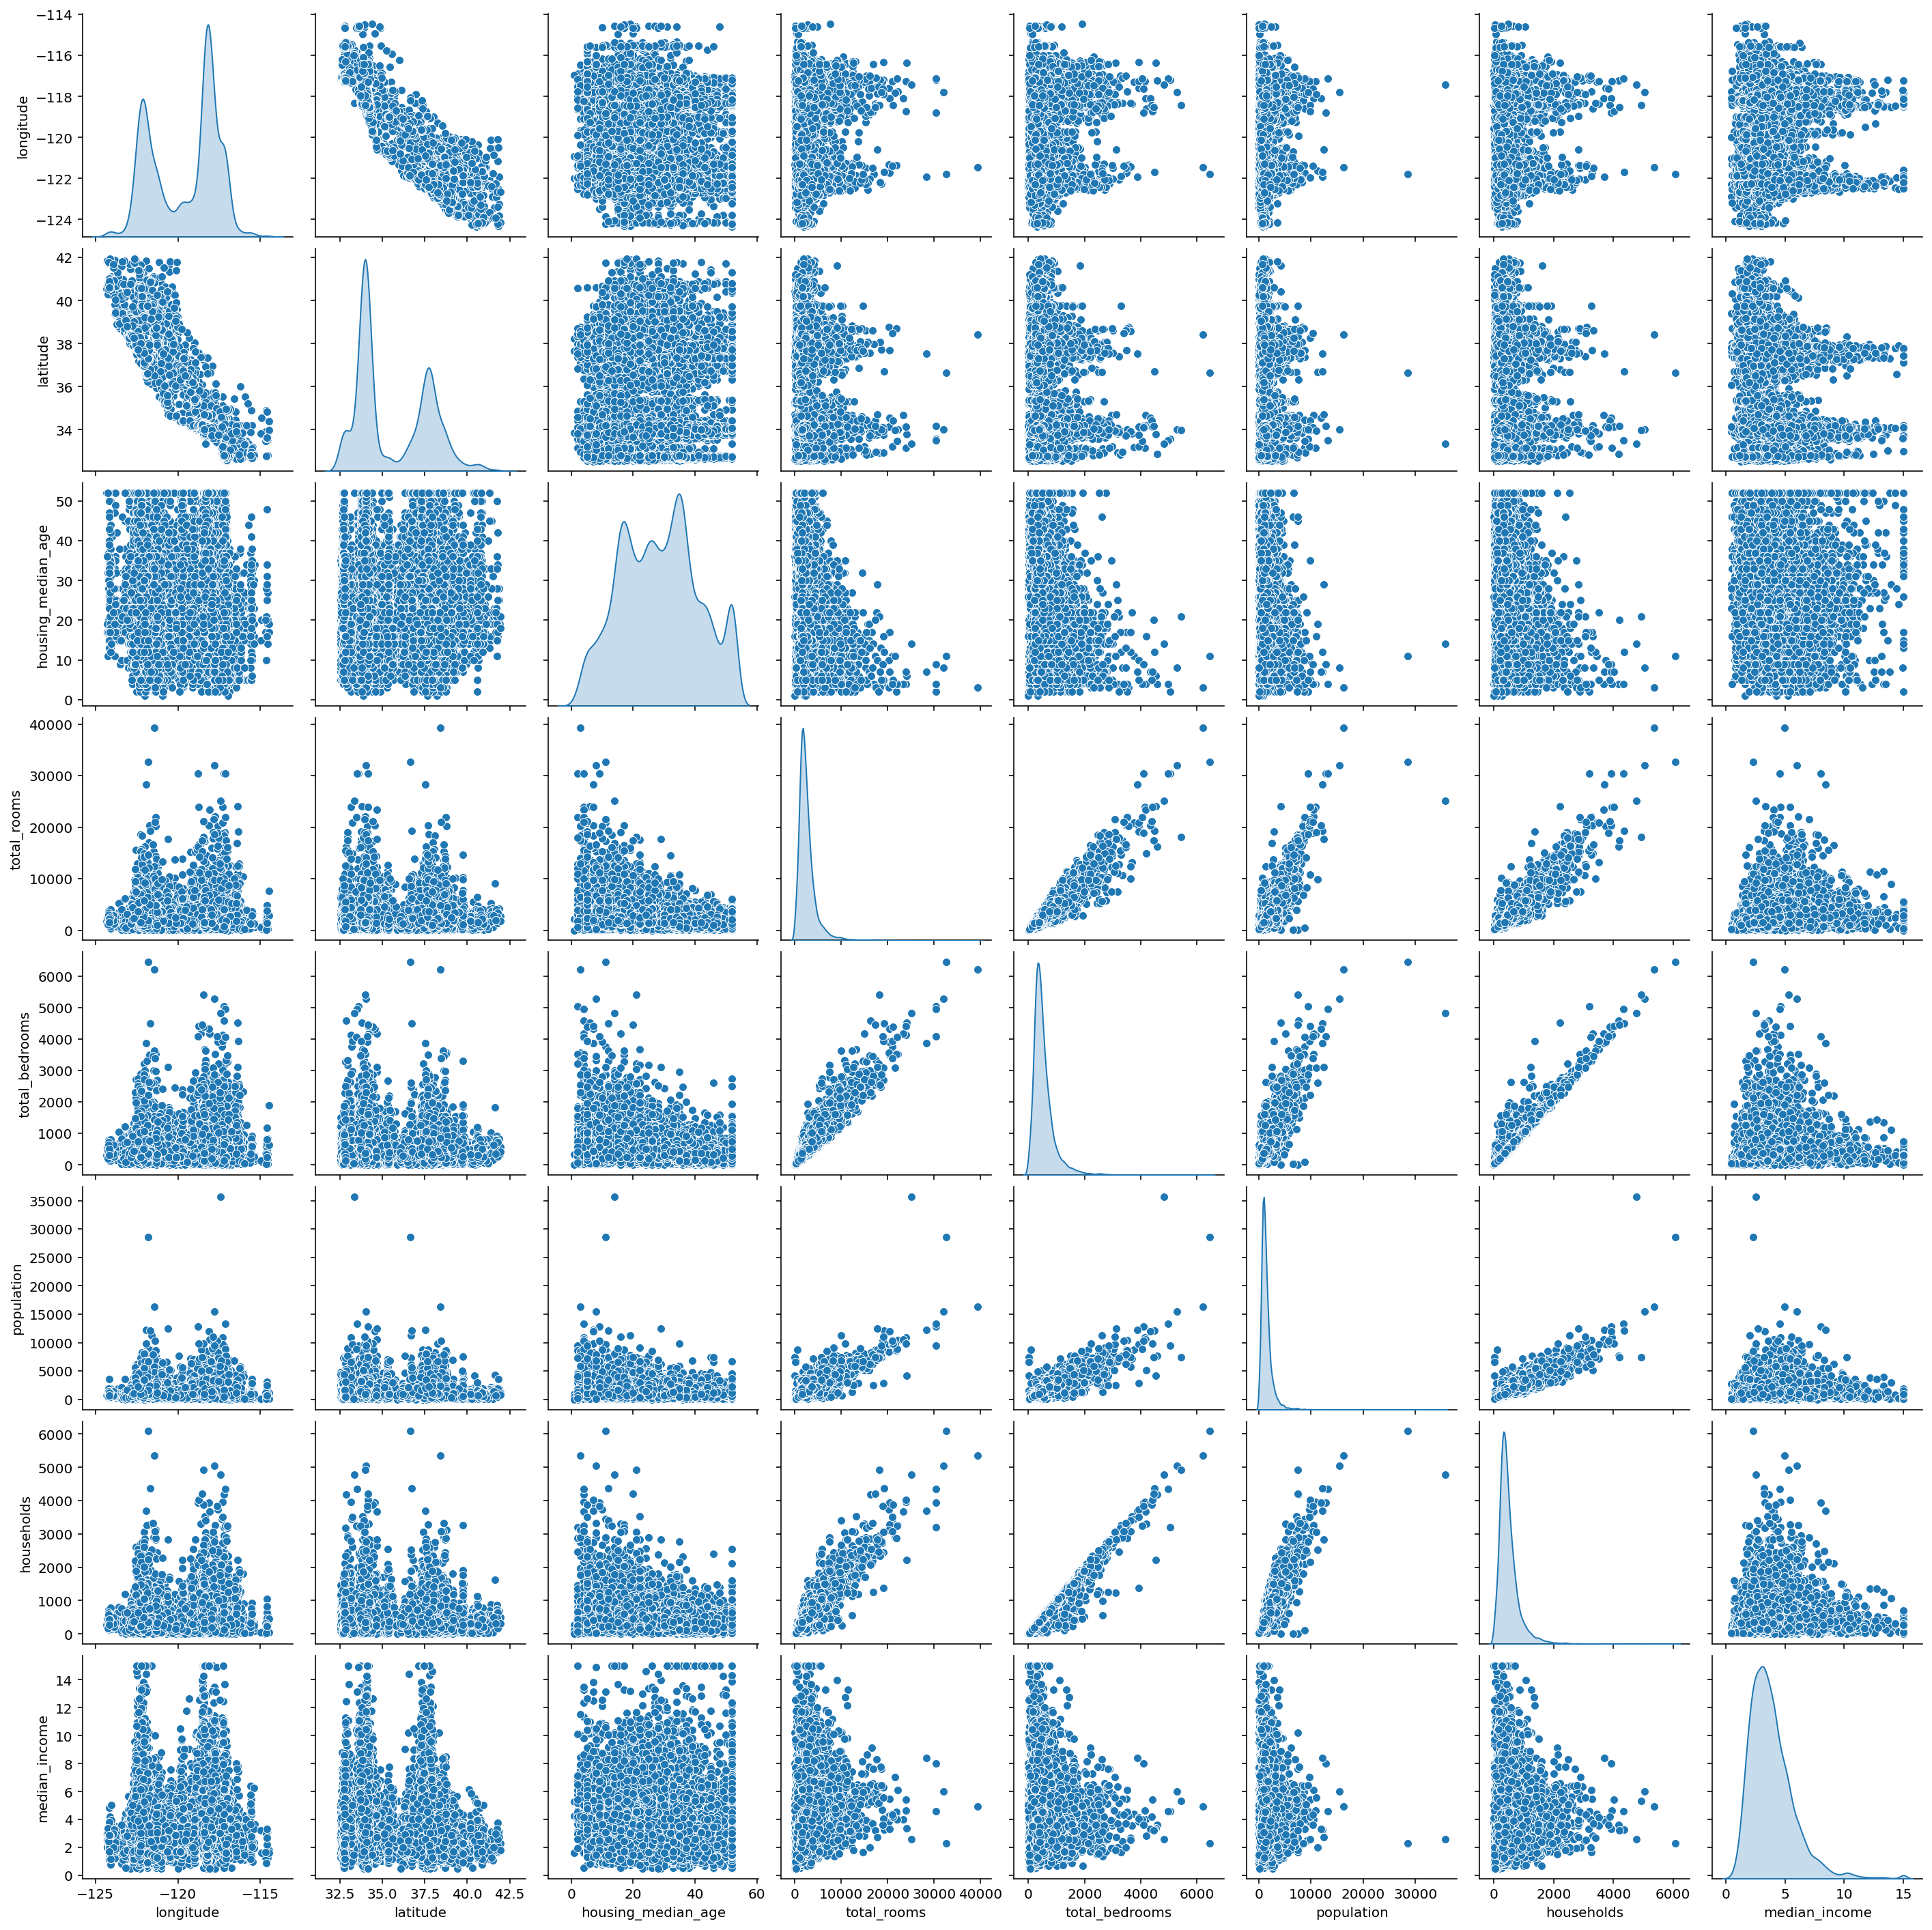

In [ ]:
# seabornのpairplot
sns.pairplot(X_train, diag_kind='kde')

### 5) 交差検証の準備

In [ ]:
# test set以外の残りを、training setとvalidation setに分ける
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape, X_valid.shape, X_test.shape)

(13076, 8) (3270, 8) (4087, 8)


In [ ]:
# 先ほどのtraining set上でモデル・パラメータを決定する
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# 先ほどのvalidation set上で評価する
y_valid_pred = reg.predict(X_valid)
print('RMSE: {:f}'.format(mean_squared_error(y_valid, y_valid_pred, squared=False)))

RMSE: 67667.758078


# 課題7

* RMSEによって評価される予測性能を、良くして下さい
* test setとそれ以外の部分の分割は、変えないでください
 * test set以外の部分をどう使うかは、自由です
 * 交差検証の方法は何でもよい。
* リッジ回帰とLASSOを使ってもいいです
* 高次多項式特徴量を使ってもいいです（sklearn.preprocessing.PolynomialFeatures）
* test setでのRMSEによる評価は最後に一回おこなうだけです


In [ ]:
# 例えば MinMaxScalerを試す。
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train) # スケーラのfitは訓練データのみで行う
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [ ]:
# そしてLassoを使ってみる。
from sklearn.linear_model import Lasso, Ridge

In [ ]:
for alpha in 10. ** np.arange(-6, 3, 1):
  lasso = Ridge(max_iter=5000, alpha=alpha, random_state=123)
  lasso.fit(X_train_scaled, y_train)
  y_valid_pred = lasso.predict(X_valid_scaled)
  print('alpha: {:f}; RMSE: {:f}'.format(
      alpha, mean_squared_error(y_valid, y_valid_pred, squared=False)
      ))

alpha: 0.000001; RMSE: 67667.758522
alpha: 0.000010; RMSE: 67667.762515
alpha: 0.000100; RMSE: 67667.802449
alpha: 0.001000; RMSE: 67668.202050
alpha: 0.010000; RMSE: 67672.223782
alpha: 0.100000; RMSE: 67714.761067
alpha: 1.000000; RMSE: 68228.951997
alpha: 10.000000; RMSE: 70924.630582
alpha: 100.000000; RMSE: 79323.075283
